# Trabajo Práctico 2: Entrenamiento y evaluación de modelos

# Configuration

In [2]:
%matplotlib inline

In [70]:
import pandas as pd
import seaborn as sns
import numpy as np
from collections import defaultdict
from matplotlib import pyplot as plt

from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn_pandas import DataFrameMapper
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelBinarizer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV


import graphviz
from sklearn.tree import export_graphviz

persons = pd.read_csv('./dataset/aug_train.csv')

# Feature Engineering

In [52]:
persons = pd.read_csv('./dataset/aug_train.csv')
#train["Gender_num"] = train.gender.replace(['Male', np.nan, 'Female', 'Other'], [0,1,2,3])
persons["Relevent_experience_num"] = persons.relevent_experience.replace(['Has relevent experience', 'No relevent experience'], [1, 0])
persons["Enrolled_university_num"] = persons.enrolled_university.replace(['no_enrollment', 'Full time course', 'Part time course',np.nan], [0, 1,0.5,np.nan]) #El nan lo sacamos, 
persons["education_level_num"] = persons.education_level.replace(['Primary School', 'High School','Graduate', 'Masters', 'Phd',np.nan], [1,2,3,4,5,np.nan]) #El nan lo sacamos, no rellenamos con nada
persons["major_discipline_num"] = persons.major_discipline.replace(['STEM', 'Business Degree', np.nan, 'Arts', 'Humanities', 'No Major','Other'], ['STEM','Other', np.nan,'Other','Other','No Major','Other'])
persons["experience_num"] = persons.experience.replace(['>20', '15', '5', '<1', '11', '13', '7', '17', '2', '16', '1', '4','10', '14', '18', '19', '12', '3', '6', '9', '8', '20', np.nan], [21,  15, 5, 0, 11, 13, 7, 17, 2, 16, 1, 4, 10, 14, 18, 19, 12, 3, 6,9, 8, 20, 10])
#train["company_type_num"] = train.company_type.replace([np.nan, 'Pvt Ltd', 'Funded Startup', 'Early Stage Startup', 'Other','Public Sector', 'NGO'], [np.nan, 1,2,3,4,5,6])
persons["company_size_num"] = persons.company_size.replace([np.nan, '50-99', '<10', '10000+', '5000-9999', '1000-4999', '10/49', '100-500', '500-999'], [np.nan, 100, 10, 20000, 10000,5000,50,500,1000]) #Nos falta aclarar por que usamos feature engineering
persons["last_new_job_num"] = persons.last_new_job.replace(['1', '>4', 'never', '4', '3', '2', np.nan], [1,5,-1,4,3,2,2])
#train["training_hours"] = train.training_hours.replace(np.nan, 47)   #No reemplazamos los nan
mapper = DataFrameMapper([
    (['gender'], [OneHotEncoder()]),
    (['major_discipline_num'], [OneHotEncoder()]),
    (['company_type'], [OneHotEncoder()]),
    (['company_size_num'], [StandardScaler()]),
    (['last_new_job_num'], [StandardScaler()]),
    (['Enrolled_university_num'], None),
    (['education_level_num'], None),
    (['experience_num'], None),
    (['Relevent_experience_num'], None),
    (['training_hours'], None),
])
mapper.fit(persons)

# Test, train & validation sets
train, not_train = train_test_split(persons, test_size=0.4, random_state=42)
validation, test = train_test_split(not_train, test_size=0.5, random_state=42)


# Entrenamiento

In [17]:
def evaluate_model(model, set_names=('train', 'validation', 'test'), title='', show_cm=True):
    if title:
        display(title)
        
    final_metrics = defaultdict(list)
    
    if show_cm:
        fig, axis = plt.subplots(1, len(set_names), sharey=True, figsize=(15, 3))
    
    for i, set_name in enumerate(set_names):
        assert set_name in ['train', 'validation', 'test']
        set_data = globals()[set_name]  # <- hack feo...

        y = set_data.target
        y_pred = model.predict(set_data)
        final_metrics['Accuracy'].append(metrics.accuracy_score(y, y_pred))
        final_metrics['Precision'].append(metrics.precision_score(y, y_pred))
        final_metrics['Recall'].append(metrics.recall_score(y, y_pred))
        final_metrics['F1'].append(metrics.f1_score(y, y_pred))
        
        if show_cm:
            ax = axis[i]
            sns.heatmap(metrics.confusion_matrix(y, y_pred), ax=ax, cmap='Blues', annot=True, fmt='.0f', cbar=False)

            ax.set_title(set_name)
            ax.xaxis.set_ticklabels(['change', 'no change'])
            ax.yaxis.set_ticklabels(['change', 'no change'])
            ax.set_xlabel('Predicted class')
            ax.set_ylabel('True class')

        
    display(pd.DataFrame(final_metrics, index=set_names))
    if show_cm:
        plt.tight_layout()
        plt.show()

## KNN

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Mejor score:  0.74848
Mejores parámetros: 
 {'n_neighbors': 20}


'Decision Tree'

,Accuracy,Precision,Recall,F1
train,0.762746,0.610870,0.099328,0.170873
validation,0.749478,0.470588,0.067227,0.117647


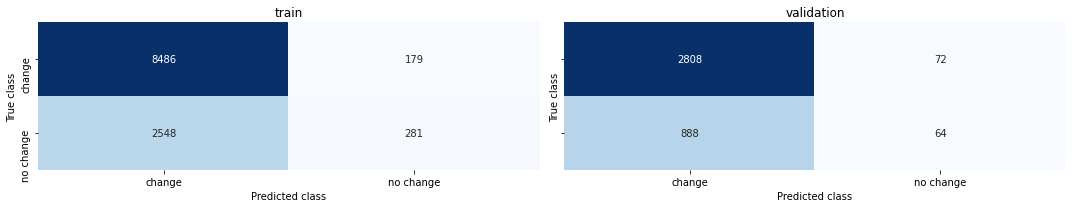

In [94]:
parameters = {'n_neighbors':[15, 20, 25]}
knn_model = KNeighborsClassifier()
clf = GridSearchCV(knn_model, parameters, refit=True, verbose=1)

dt_model = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', clf),
])

dt_model.fit(train, train.target)

print('Mejor score: ', round(clf.best_score_, 5))
print('Mejores parámetros: \n', clf.best_params_)
evaluate_model(dt_model, title='Decision Tree', set_names=('train', 'validation'))

## Decission Tree

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Mejor score:  0.76379
Mejores parámetros: 
 {'max_depth': 5}


'Decision Tree'

,Accuracy,Precision,Recall,F1
train,0.768662,0.574431,0.231884,0.330395
validation,0.758090,0.531646,0.220588,0.311804


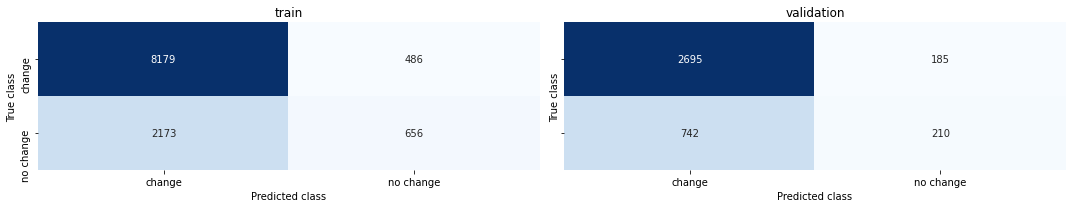

In [90]:
parameters = {'max_depth':[3, 5, 8]}
tree_model = DecisionTreeClassifier(max_depth=5)
clf = GridSearchCV(tree_model, parameters, refit=True, verbose=1)

dt_model = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', clf),
])

dt_model.fit(train, train.target)

print('Mejor score: ', round(clf.best_score_, 5))
print('Mejores parámetros: \n', clf.best_params_)
evaluate_model(dt_model, title='Decision Tree', set_names=('train', 'validation'))

In [55]:
def graph_tree(tree, col_names):
    graph_data = export_graphviz(
        tree, 
        out_file=None, 
        feature_names=col_names,  
        class_names=['change', 'no change'],  
        filled=True, 
        rounded=True,  
        special_characters=True,
    )
    graph = graphviz.Source(graph_data)  
    return graph

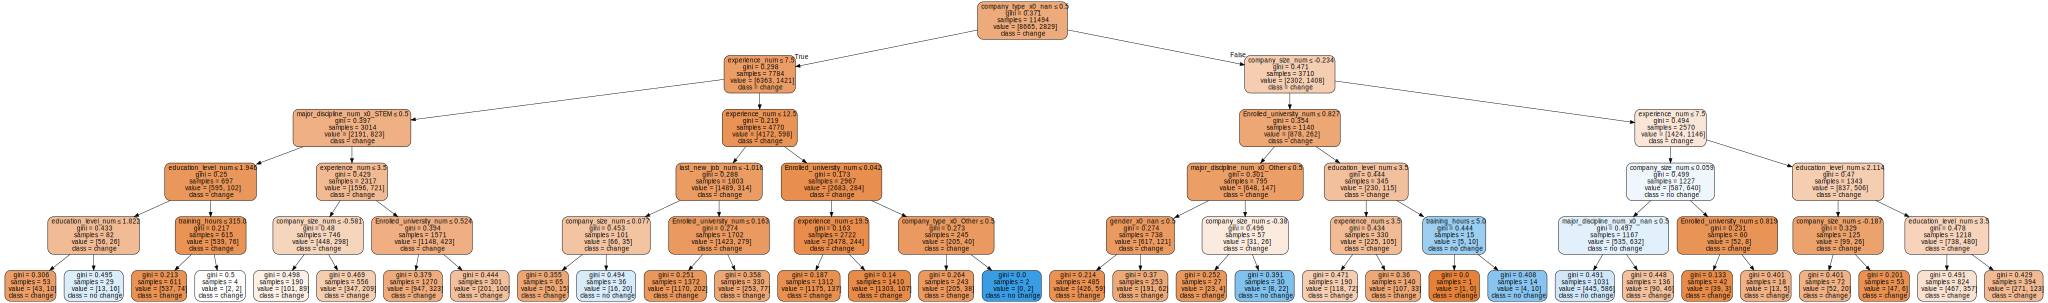

In [91]:
graph_tree(clf.best_estimator_, binarizer_mapper.transformed_names_)

## Métrica de Performance
* Precission: Determinar que porcentaje de las veces que dijimos positivo acertamos. Es insuficiente por si sola.

* Recall: Como complemento de precission, indica el porcentaje de positivos que encontramos por sobre los reales.

* F1-Score: Combina las anteriores.

## Evaluación

## Sobreentrenamiento

## Valor real